# Overview

Stable Diffusion XL includes a [refiner model](https://huggingface.co/stabilityai/stable-diffusion-xl-refiner-1.0) specialized in denoising low-noise stage images to generate higher-quality images from the base model. There are two ways to use the refiner:

1. use the base and refiner models together to produce a refined image(known as an ensemble of expert denoisers)
2. use the base model to produce an image, and subsequently use the refiner model to add more details to the image(this is how SDXL was originally trained)

In [1]:
!pip install diffusers==0.23.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.9 MB/s eta 0:00:00


# 1. Base + refiner model

The ensemble of expert denoisers approach requires fewer overall denoising steps versus passing the base model's output to the refiner model, so it should be significantly faster to run. However, you won't be able to inspect the base model's output because it still contains a large amount of noise.

As an ensemble of expert denoisers, the base model serves as the expert during the high-noise diffusion stage and the refiner model serves as the expert during the low-noise diffusion stage. Load the base and refiner model:

In [2]:
from diffusers import DiffusionPipeline
import torch

base=DiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-xl-base-1.0', 
                                       torch_dtype=torch.float16,
                                       use_safetensors=True,
                                       variant='fp16')
base.enable_model_cpu_offload()
base

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

2024-02-06 05:49:06.797939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 05:49:06.798042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 05:49:06.949616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.23.1",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [3]:
refiner=DiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-xl-refiner-1.0',
                                         text_encoder_2=base.text_encoder_2, 
                                          vae=base.vae, 
                                          torch_dtype=torch.float16, 
                                          use_safetensors=True, variant='fp16')
refiner.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

To use this approach, we need to define the number of timesteps for each model to run through their respective stages. For the base model, this is controlled by the denoising_end parameter and for the refiner model, it is controlled by the denoising_start parameter.

> The denoising_end and denoising_start parameters should be a float between 0 and 1. These parameters are represented as a proportion of discrete timesteps as defined by the scheduler. If you are also using the `strength` parameter, it'll be ignored because the number of denoising steps is determined by the discrete timesteps the model is trained on and the declared fractional cutoff.


Let's set `denoising_end=0.8` so the base model performs the first 80% of denoising the **high-noise** timesptes and set `denoising_start=0.8` so the refiner model performs the last 20% of denoising the **low-noise** timesteps. The base model output should be in **latent** space instead of a PIL image.

## Text2Image

In [4]:
from diffusers.utils import load_image, make_image_grid

prompt='A causal language models trainer of the machine learning is hard working on the training process.'

image_base=base(prompt=prompt, num_inference_steps=40, denoising_end=0.8, output_type='latent').images

image_optim=refiner(prompt=prompt, num_inference_steps=40, denoising_start=0.8, image=image_base).images[0]
image_optim.save('causal_language_trainer.png')

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

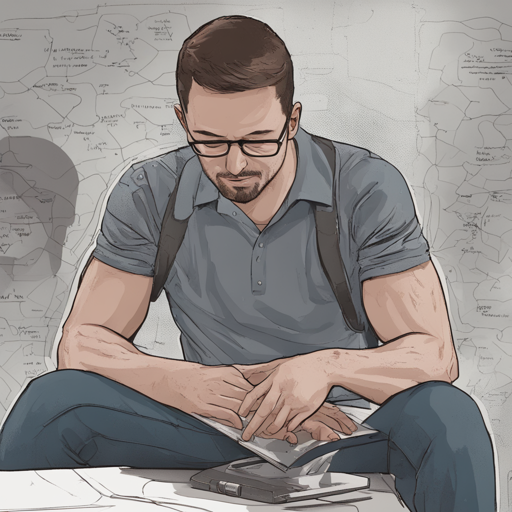

In [5]:
make_image_grid([image_optim.resize((512,512))], rows=1, cols=1)

# Base to reinfer model

SDXL gets a boost in image quality by using the refiner model to add additional high-quality details to the fully-denoised image from the base model, in an image-to-image setting

Here we use the base and refiner models same above, but we generate an image from the base model, and set the model output to latent space:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

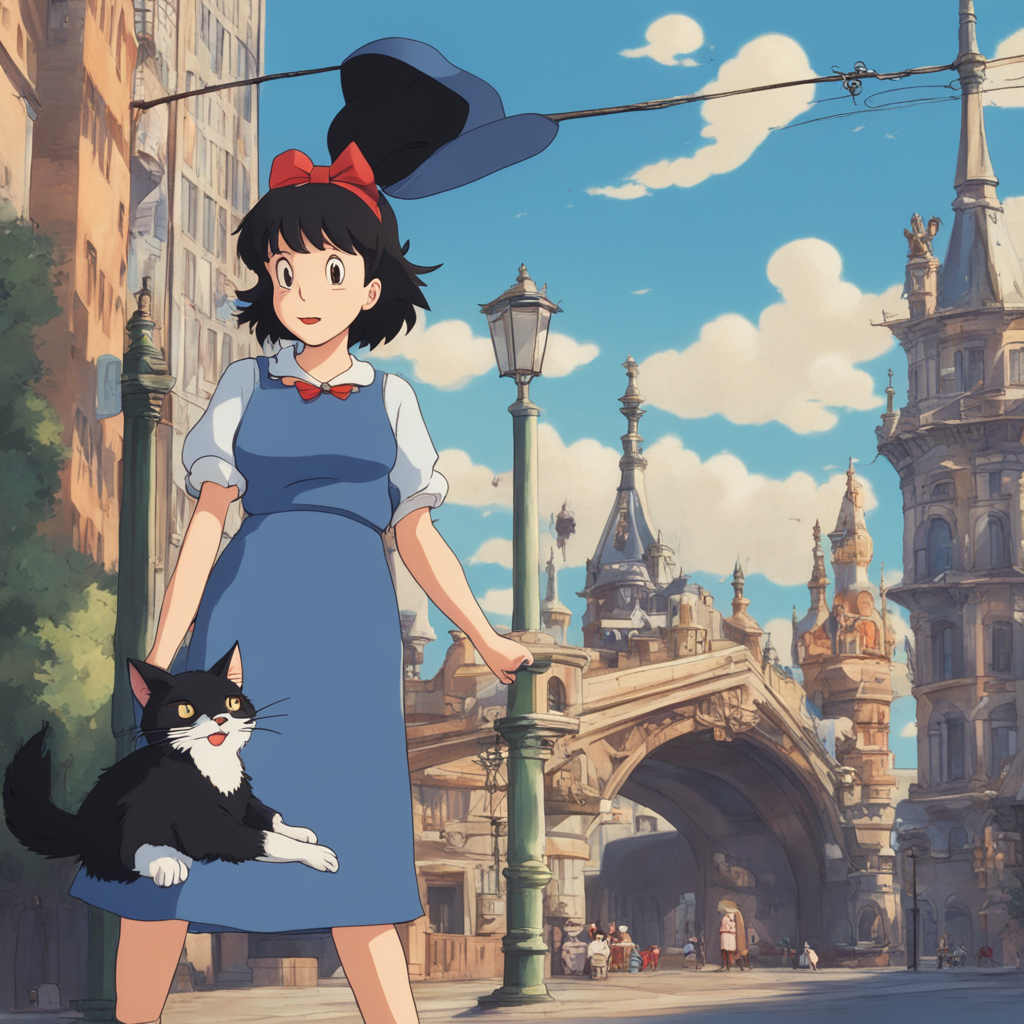

In [6]:
prompt="Kiki's delivery service, background is Melbourne's blue sky, 8K"

image_base=base(prompt=prompt, output_type="latent").images[0]
image_optim=refiner(prompt=prompt, image=image_base[None, :]).images[0]

make_image_grid([image_optim], rows=1,cols=1)

# Inpainting

In [7]:
import gc

del base, refiner, prompt, image_base, image_optim
gc.collect()

torch.cuda.empty_cache()

In [8]:
from diffusers import StableDiffusionXLInpaintPipeline
from diffusers.utils import load_image

base=StableDiffusionXLInpaintPipeline.from_pretrained(
    'stabilityai/stable-diffusion-xl-base-1.0',
    torch_dtype=torch.float16,
    variant='fp16',
    use_safetensors=True)
base.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
refiner=StableDiffusionXLInpaintPipeline.from_pretrained(
    'stabilityai/stable-diffusion-xl-refiner-1.0',
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant='fp16',
)
refiner.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

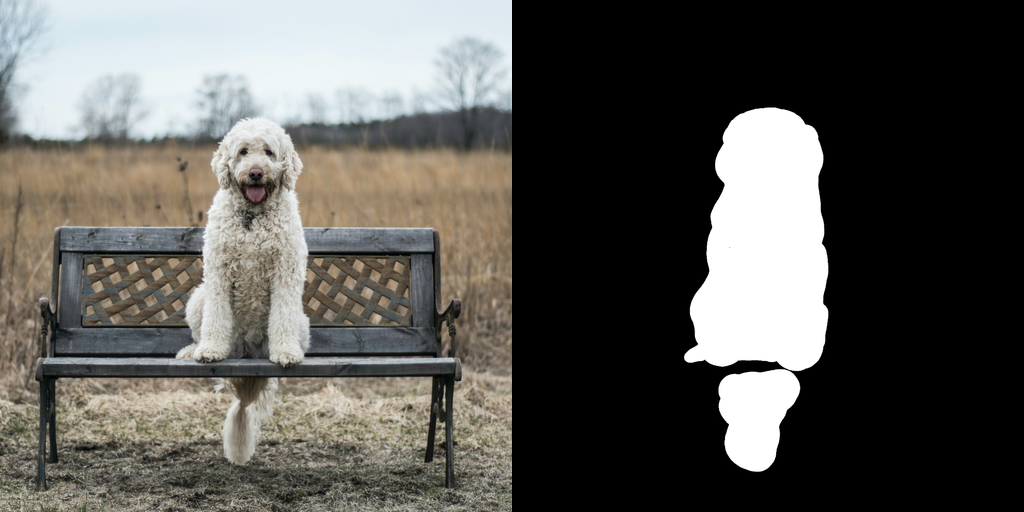

In [10]:
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image=load_image(img_url)
mask_image=load_image(mask_url)
make_image_grid([init_image, mask_image], rows=1, cols=2)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

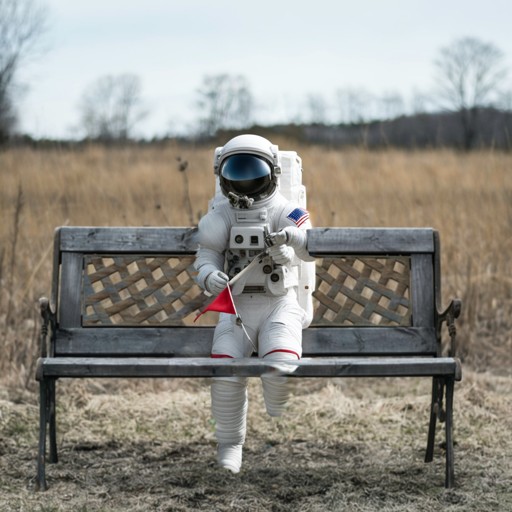

In [11]:
prompt="Astronaut handles a RMIT university's flag and set down in here"
num_inference_steps=75
high_noise_frac=0.7

image_base=base(prompt, image=init_image, mask_image=mask_image, 
                num_inference_steps=num_inference_steps,
                denoising_end=high_noise_frac, output_type='latent').images

image=refiner(prompt=prompt, image=image_base, mask_image=mask_image, 
              num_inference_steps=num_inference_steps,
              denoising_start=high_noise_frac).images[0]

make_image_grid([image.resize((512,512))], rows=1,cols=1)